
# Ehlers Cybernetic analysis for stocks and futures
## Chapter 3

In [10]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 14, 7

In [11]:
# Import some useful libraries and tools
import pandas as pd
import numpy as np
from scipy import signal
from numpy import pi

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

In [12]:
def bode_plot(h, w, plot_title='Bode plot'):
    """
    Bode amplitude and phase plot function
    """
    dB = 20 * np.log10(abs(h))
    phi = np.unwrap(np.angle(h))
    
#    lag = - (phi / 360) * (2.0 / (w / pi)) 
    
    w_ = w / (2 * pi)     # Set frequency in Cycles per day.
    fig, axs = plt.subplots(2, 1, sharex=True)

    plt.suptitle(plot_title, fontsize=16)
    
    axs[0].plot(w_, dB, 'b')
    axs[0].set_ylabel('Amplitude (dB)', color='b', fontsize=14)
    axs[0].grid()
        
    axs[1].plot(w_, phi, 'g')
    axs[1].set_ylabel(r'$\phi $ (deg)', color='g', fontsize=14)
    axs[1].set_xlabel('Frequency (Cycles per day)', fontsize=12)
    axs[1].set_xlim(xmax = 0.5)
    axs[1].grid()
    plt.show()

In [13]:
# Now load some data, specifically AAPL minute data from 2015-07-14
df = pd.read_csv('https://drive.google.com/uc?export=download&id=0B9-kA56h5JCMbXptY0kyVXZXaUU',
                 index_col=0, parse_dates=True)
x = df.CLOSE.as_matrix()

From page 21:
>The rationale for the leading trigger is that adding the two-day momen-
tum to the current value in a trend is predicting where the Instantaneous
Trendline will be two days from now. 

Defining the Leading trigger as:
$$
\\LT[n] = 2IT[n] - IT[n-2]\\
\\LT[n] = 2IT[n] - IT[n]z^{-2}\\
\\LT[n] = IT[n](2-z^{-2})\\
\\LT(n)= \frac{\left (\alpha-\frac{\alpha^2}{4}\right) + \frac{\alpha^2}{2}z^{-1} - \left (\alpha-\frac{3\alpha^2}{4}\right) z^{-2}}
{1 - 2(1 - \alpha ) z^{-1}+(1 - \alpha )^2 z^{-2}}(2-z^{-2})\\
$$
assume: ${\alpha}' = (\frac{\alpha}{2})^2$
$$
\\LT(n)= \frac{2(\alpha - {\alpha}') + 4{\alpha}'z^{-1} -(3\alpha - 7{\alpha}')z^{-2}
- 2{\alpha}'z^{-3} + (\alpha - 3{\alpha}')z^{-4}}
{1 - 2(1 - \alpha ) z^{-1}+(1 - \alpha )^2 z^{-2}}\\
$$



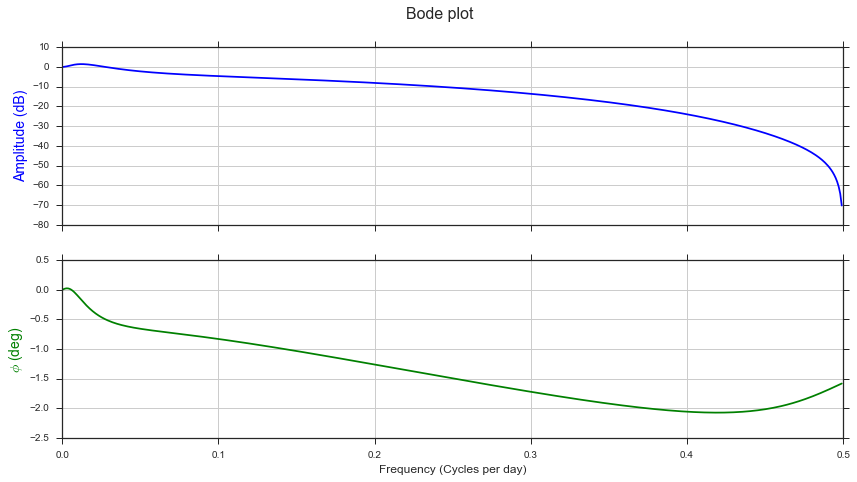

In [14]:
SMA_lag = 20
alpha = 2.0 / (SMA_lag + 1)

a_ = (alpha / 2) ** 2
b_ = (1 - alpha)

# IT indicator
numerator = np.array([alpha - a_, 2 * a_, -(alpha - 3 * a_)])
denominator = np.array([1.0, -2 * b_, b_ ** 2])

zi = signal.lfiltic(numerator, denominator, y=x, x=x)
IT = signal.lfilter(numerator, denominator, x, zi=zi)


# IT Lead Trigger
numerator = np.array([2 * (alpha - a_),  4 * a_, -(3 * alpha - 7 * a_),
                      -2 * a_, (alpha - 3 * a_)])
denominator = np.array([1.0, -2 * b_,  b_ ** 2])

zi = signal.lfiltic(numerator, denominator, y=x, x=x)  
LT = signal.lfilter(numerator, denominator, x, zi=zi) 

w, h = signal.freqz(numerator, denominator)
bode_plot(h, w)

The results are not similar to the ones in the book. However, the Lead Trigger indeed shows a lead in the pahse in low frequencies.

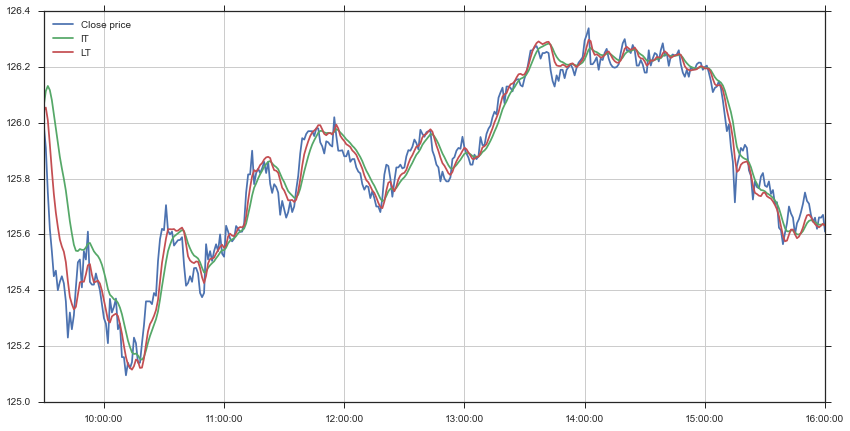

In [15]:
plt.plot(df.index, x, label='Close price')
plt.plot(df.index, IT[0], label='IT')
plt.plot(df.index, LT[0], label='LT')
plt.grid()
plt.legend(loc='upper left')